In [166]:
from scipy import stats as st
from matplotlib import pyplot as plt
import math as mt
import pandas as pd
import numpy as np

# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

Data is split among 4 main separate data sets.
Users, Calls, Messages, Internet

The main goal is to eventually evaluate and perform hypothesis testing on the average revenue from users with the different calling plans.

In order to get to this point, the data has to be processed to calculate the revenue based from the individual users calling information, texts/messages sent, and data from internet used given the charges based on the calling and data plans. Because of the amount of the information provided, statistics on the user based on their calls, messages, and internet usage can be generated and described as well.

First, what needs to be done is to process the data. Analyze the dataset to see what needs to be cleaned up, parsed, and processed to make subsequent analysis easier. Individual calls, messages, data usage can be grouped by user, and revenue can be determined based on this data. From there, further steps to process the data based on the question we want to probe with the data can be determined.

## Load data

In [167]:
# Load the data files into different DataFrames
plans = pd.read_csv('datasets/megaline_plans.csv')
users = pd.read_csv('datasets/megaline_users.csv')
calls = pd.read_csv('datasets/megaline_calls.csv')
internet = pd.read_csv('datasets/megaline_internet.csv')
messages = pd.read_csv('datasets/megaline_messages.csv')

## Prepare the data

## Plans

In [168]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [169]:
# Print a sample of data for plans
display(plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Table presents overview of the differences between plans 'surf' and 'ultimate'. 

- `usd_monthly_fee` — monthly charge in US dollars
- `minutes_included` — monthly minute allowance
- `messages_included` — monthly text allowance
- `mb_per_month_included` — data volume allowance (in megabytes)
- `usd_per_minute` — price per minute after exceeding the package limits
- `usd_per_message` — price per text after exceeding the package limits
- `usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

### Enrich data

Since charges are determined by GBs, convert the mb_per_month_included to units of gb

In [170]:
# Change mb_per_month_included to gb_per_month_included
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024

## Users

In [171]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [172]:
# Print a sample of data for users
display(users.head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [173]:
# Check for any fully duplicate rows
print(users.duplicated().sum())

# Check for duplicate user_id
print(users['user_id'].duplicated().sum())

# Check plan only contains the two specified plans
print(users['plan'].unique())

0
0
['ultimate' 'surf']


Overall impression of the users dataset
- 500 entries
- no issues with column names
- need to convert `reg_date` to datetime format
- other column dtypes look good
- missing values in churn_date is not an issue

### Fix Data

In [174]:
# Convert reg_date to datetime format
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### Enrich data

Add column data to flag if user is from NY-NJ or not

In [175]:
# Function to determine if str contains NY-NJ
def contains_nynj(value):
    '''
    Function that returns whether city contains NY-NJ
    Returns 1 if NY-NJ is in string
    Returns 0 otherwise
    '''
    if 'NY-NJ' in value:
        return 1
    else:
        return 0

In [176]:
# Pull NY-NJ from city column and adds column
users['NYNJ'] = users['city'].apply(contains_nynj)

## Calls

In [177]:
# Print the general/summary information about the calls' DataFrame
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [178]:
# Print a sample of data for calls
calls.sample(5)

,id,user_id,call_date,duration
29402,1111_29,1111,2018-11-17,8.11
94856,1336_787,1336,2018-04-22,0.00
58034,1209_573,1209,2018-09-24,0.00
137647,1499_116,1499,2018-11-08,0.38
11271,1050_42,1050,2018-10-19,0.00


In [179]:
# Check for any fully duplicate rows
calls.duplicated().sum()

0

- No missing values/data
- No fully duplicated rows
- Need to change `call_date` type to datetime
- `duration` is in minutes

### Fix data

In [180]:
# Convert call_date to datetime format
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

### Enrich data

In [181]:
# Pull month of the call data to a new column
calls['month'] = calls['call_date'].dt.month

## Messages

In [182]:
# Print the general/summary information about the messages' DataFrame
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [183]:
# Print a sample of data for messages
messages.sample(5)

,id,user_id,message_date
66231,1433_171,1433,2018-11-20
51615,1335_205,1335,2018-11-04
4695,1044_52,1044,2018-10-08
48640,1326_177,1326,2018-09-25
19125,1124_12,1124,2018-12-27


In [184]:
# Check for fully duplicated rows
messages.duplicated().sum()

0

- 76051 entries, no missing values
- Need to convert `message_date` to datetime format
- No fully duplicated rows

### Fix data

In [185]:
# Change message_date to datetime format
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

### Enrich data

In [186]:
# Add month column for message_date
messages['month'] = messages['message_date'].dt.month

## Internet

In [187]:
# Print the general/summary information about the internet DataFrame
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [188]:
# Print a sample of data for the internet traffic
internet.sample(5)

,id,user_id,session_date,mb_used
21663,1099_417,1099,2018-06-08,0.00
101573,1486_112,1486,2018-12-16,0.00
91409,1421_30,1421,2018-10-31,437.09
21054,1098_80,1098,2018-12-11,545.95
72565,1337_49,1337,2018-11-11,0.00


In [189]:
# Check for fully duplicated rows
internet.duplicated().sum()

0

- 104825 entires, no missing values
- No fully duplicated rows
- Need to change session_date to datetime format

### Fix data

In [190]:
# Change session_date to datetime format
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Enrich data

From the internet data:
- Pull out the month
- Convert mb_used to gb_used

In [191]:
# Add month column for session_date
internet['month'] = internet['session_date'].dt.month

# Convert mb_used to gb_used
internet['gb_used'] = internet['mb_used'] / 1024

In [192]:
# Function that rounds up to the nearest gb used
def roundup(value):
    return mt.ceil(value)

## Study plan conditions

In [193]:
# Print out the plan conditions and make sure they are clear for you
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Aggregate data per user

In [194]:
# Using pivot table to sum up the total minutes per user_id
pivot_calls = np.ceil(pd.pivot_table(calls, index=['user_id', 'month'], values='duration', aggfunc='sum')).reset_index()

print(pivot_calls)

# Using groupby to sum up the total minutes per user_id
groupby_calls = np.ceil(calls.groupby(['user_id', 'month']).agg(duration = ('duration', 'sum'))).reset_index()
print(groupby_calls)

# Check if both arrays are equal
np.array_equal(pivot_calls, groupby_calls)

      user_id  month  duration
0        1000     12     117.0
1        1001      8     172.0
2        1001      9     298.0
3        1001     10     375.0
4        1001     11     405.0
...       ...    ...       ...
2253     1498     12     325.0
2254     1499      9     331.0
2255     1499     10     364.0
2256     1499     11     289.0
2257     1499     12     469.0

[2258 rows x 3 columns]
      user_id  month  duration
0        1000     12     117.0
1        1001      8     172.0
2        1001      9     298.0
3        1001     10     375.0
4        1001     11     405.0
...       ...    ...       ...
2253     1498     12     325.0
2254     1499      9     331.0
2255     1499     10     364.0
2256     1499     11     289.0
2257     1499     12     469.0

[2258 rows x 3 columns]


True

In [195]:
# Using pivot table to count the total messages sent per user_id
pivot_msgs = pd.pivot_table(messages, index=['user_id', 'month'], values='id', aggfunc='count').reset_index()

print(pivot_msgs)

# Using groupby to count the total messages sent per user_id
groupby_msgs = messages.groupby(['user_id', 'month']).agg(id = ('id', 'count')).reset_index()
print(groupby_msgs)

# Check if both arrays are equal
np.array_equal(pivot_msgs, groupby_msgs)

      user_id  month  id
0        1000     12  11
1        1001      8  30
2        1001      9  44
3        1001     10  53
4        1001     11  36
...       ...    ...  ..
1801     1496      9  21
1802     1496     10  18
1803     1496     11  13
1804     1496     12  11
1805     1497     12  50

[1806 rows x 3 columns]
      user_id  month  id
0        1000     12  11
1        1001      8  30
2        1001      9  44
3        1001     10  53
4        1001     11  36
...       ...    ...  ..
1801     1496      9  21
1802     1496     10  18
1803     1496     11  13
1804     1496     12  11
1805     1497     12  50

[1806 rows x 3 columns]


True

In [196]:
# Using pivot table to count the total data used per month
pivot_internet = np.ceil(pd.pivot_table(internet, index=['user_id', 'month'], values='gb_used', aggfunc='sum')).reset_index()
print(pivot_internet)

# Using groupby to sum the total data used per month
groupby_internet = np.ceil(internet.groupby(['user_id', 'month']).agg(gbs = ('gb_used', 'sum'))).reset_index()
print(groupby_internet)

# Check if both arrays are equal
np.array_equal(pivot_internet, groupby_internet)

      user_id  month  gb_used
0        1000     12      2.0
1        1001      8      7.0
2        1001      9     14.0
3        1001     10     22.0
4        1001     11     19.0
...       ...    ...      ...
2272     1498     12     23.0
2273     1499      9     13.0
2274     1499     10     20.0
2275     1499     11     17.0
2276     1499     12     22.0

[2277 rows x 3 columns]
      user_id  month   gbs
0        1000     12   2.0
1        1001      8   7.0
2        1001      9  14.0
3        1001     10  22.0
4        1001     11  19.0
...       ...    ...   ...
2272     1498     12  23.0
2273     1499      9  13.0
2274     1499     10  20.0
2275     1499     11  17.0
2276     1499     12  22.0

[2277 rows x 3 columns]


True

In [197]:
# Merging calls and messages
merge1 = pivot_calls.merge(pivot_msgs, on=['user_id', 'month'], how='outer')

# Merging calls/messages and gbs used
merge2 = merge1.merge(pivot_internet, on=['user_id', 'month'], how='outer').fillna(0)

# Merging users with calls/messages/gbs
merge3 = merge2.merge(users, on='user_id', how='left')

# Merging plans
merge4 = merge3.merge(plans, left_on='plan', right_on='plan_name', how='left')

In [198]:
# Calculate revenue per user per month
def rev_user(row):
    mins_over_limit = row['duration'] - row['minutes_included']
    if mins_over_limit < 0:
        mins_over_limit = 0

    msgs_over_limit = row['id'] - row['messages_included']
    if msgs_over_limit < 0:
        msgs_over_limit = 0
    
    gbs_over_limit = row['gb_used'] - row['gb_per_month_included']
    if gbs_over_limit < 0:
        gbs_over_limit = 0
        
    total = row['usd_monthly_pay'] + (row['usd_per_gb']*gbs_over_limit) + (row['usd_per_message']*msgs_over_limit) + (row['usd_per_minute']*mins_over_limit)
    return total

In [199]:
# Apply revenue
merge4['revenue'] = merge4.apply(rev_user, axis=1)

In [200]:
print(merge4)

      user_id  month  duration    id  gb_used  first_name  last_name  age  \
0        1000     12     117.0  11.0      2.0    Anamaria      Bauer   45   
1        1001      8     172.0  30.0      7.0      Mickey  Wilkerson   28   
2        1001      9     298.0  44.0     14.0      Mickey  Wilkerson   28   
3        1001     10     375.0  53.0     22.0      Mickey  Wilkerson   28   
4        1001     11     405.0  36.0     19.0      Mickey  Wilkerson   28   
...       ...    ...       ...   ...      ...         ...        ...  ...   
2288     1349     12       0.0  61.0     13.0  Florentina       Diaz   69   
2289     1361      5       0.0   2.0      2.0     Jacelyn    Hoffman   45   
2290     1482     10       0.0   2.0      0.0      Armand      Glenn   70   
2291     1108     12       0.0   0.0      1.0    Porfirio       Kane   45   
2292     1311      6       0.0   0.0      2.0     Cherlyn   Saunders   69   

                                           city   reg_date  ...  \
0       

In [201]:
# Calculate the number of calls made by each user per month. Save the result.
calls_mon_user = calls.groupby(['user_id', 'month']).agg(calls_month = ('id', 'count'))

# Calculate the amount of minutes spent by each user per month. Save the result.
callmins_mon_user = calls.groupby(['user_id', 'month']).agg(min_month = ('duration', 'sum'))

# Calculate the number of messages sent by each user per month. Save the result.
msg_mon_user = messages.groupby(['user_id', 'month']).agg(number_of_msgs = ('id', 'count'))

# Calculate the volume of internet traffic used by each user per month. Save the result.
gb_mon_user = internet.groupby(['user_id', 'month']).agg(gb_month = ('gb_used', 'sum'))

# Rounding up to the nearest gb used per month
gb_mon_user['gb_month'] = gb_mon_user['gb_month'].apply(roundup)

In [202]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
merged_data = calls_mon_user.merge(callmins_mon_user, on=['user_id', 'month'], how='outer')
merged_data = merged_data.merge(msg_mon_user, on=['user_id', 'month'], how='outer')
merged_data = merged_data.merge(gb_mon_user, on=['user_id', 'month'], how='outer')

merged_data.info()
# Fill missing values with 0 and reset_index
merged_data = merged_data.reset_index().fillna(0)

# Add the plan information
merged_users = merged_data.merge(users, on='user_id', how='left')

merged_users_plans = merged_users.merge(plans, left_on='plan', right_on='plan_name', how='left')

# Print information on the merged data set
merged_users_plans.info()
merged_users_plans.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1311, 6)
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calls_month     2258 non-null   float64
 1   min_month       2258 non-null   float64
 2   number_of_msgs  1806 non-null   float64
 3   gb_month        2277 non-null   float64
dtypes: float64(4)
memory usage: 98.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2293 non-null   int64         
 1   month                  2293 non-null   int64         
 2   calls_month            2293 non-null   float64       
 3   min_month              2293 non-null   float64       
 4   number_of_msgs         2293 non-null   float64       
 5   gb_month               2293 non-null   float

,user_id,month,calls_month,min_month,number_of_msgs,gb_month,first_name,last_name,age,city,...,NYNJ,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,1000,12,16.0,116.83,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,0,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0
1,1001,8,27.0,171.14,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0,50,15360,500,20,10,0.03,0.03,surf,15.0
2,1001,9,49.0,297.69,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0,50,15360,500,20,10,0.03,0.03,surf,15.0
3,1001,10,65.0,374.11,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0,50,15360,500,20,10,0.03,0.03,surf,15.0
4,1001,11,64.0,404.59,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,0,50,15360,500,20,10,0.03,0.03,surf,15.0


In [203]:
# Calculating messages used over the allocated amount per plan
def msgs_over(row):
    '''
    Function that returns the number of messages over the plan limit to be charged
    Returns 0 if user used less than the plan limit
    Or returns the number of messages over the plan limit
    '''
    plan_limit = row['messages_included']
    msg_used = row['number_of_msgs']
    msgs_over_limit = msg_used - plan_limit
    
    if (msgs_over_limit < 0):
        return 0
    else:
        return msgs_over_limit    
        

 # Calculating data used over the allocated amount per plan
def gbs_over(row):
    '''
    Function that returns the data used over the plan limit to be charged
    Returns 0 if user used less than the plan limit
    Or returns the number of gbs over the plan limit
    '''
    plan_limit = row['gb_per_month_included']
    gb_used = row['gb_month']
    gbs_over_limit = gb_used - plan_limit
    
    if (gbs_over_limit < 0):
        return 0
    else:
        return gbs_over_limit 
 

 # Calculating minutes used over the allocated amount per plan
def mins_over(row):
    '''
    Function that returns the minutes used over the plan limit to be charged
    Returns 0 if user used less than the plan limit
    Or returns the number of minutes over the plan limit
    '''
    plan_limit = row['minutes_included']
    mins_used = row['min_month']
    mins_over_limit = mins_used - plan_limit
    
    if (mins_over_limit < 0):
        return 0
    else:
        return mins_over_limit

In [204]:
 # Add column for messages over plan limit
merged_users_plans['msgs_over'] = merged_users_plans.apply(msgs_over, axis=1)

# Add column for gb over plan limit
merged_users_plans['gb_over'] = merged_users_plans.apply(gbs_over, axis=1)

# Add column for mins over plan limit
merged_users_plans['min_over'] = merged_users_plans.apply(mins_over, axis=1)

In [205]:
 # Calculate monthly charge
def monthly_charge(row):
    # Function that calculates and returns the total monthly charge
    base = row['usd_monthly_pay']
    data = row['usd_per_gb'] * row['gb_over']
    msg = row['usd_per_message'] * row['msgs_over']
    minute = row['usd_per_minute'] * row['min_over']
    sum = base + data + msg + minute
    return sum 

In [206]:
# Add column for charge per month
merged_users_plans['charge_month'] = merged_users_plans.apply(monthly_charge, axis=1)
 
# Print out resulting info and sample rows
merged_users_plans.info()
merged_users_plans.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2293 non-null   int64         
 1   month                  2293 non-null   int64         
 2   calls_month            2293 non-null   float64       
 3   min_month              2293 non-null   float64       
 4   number_of_msgs         2293 non-null   float64       
 5   gb_month               2293 non-null   float64       
 6   first_name             2293 non-null   object        
 7   last_name              2293 non-null   object        
 8   age                    2293 non-null   int64         
 9   city                   2293 non-null   object        
 10  reg_date               2293 non-null   datetime64[ns]
 11  plan                   2293 non-null   object        
 12  churn_date             158 non-null    object        
 13  NYN

,user_id,month,calls_month,min_month,number_of_msgs,gb_month,first_name,last_name,age,city,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,msgs_over,gb_over,min_over,charge_month
0,1000,12,16.0,116.83,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,70,7,0.01,0.01,ultimate,30.0,0.0,0.0,0.0,70.00
1,1001,8,27.0,171.14,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,20,10,0.03,0.03,surf,15.0,0.0,0.0,0.0,20.00
2,1001,9,49.0,297.69,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,20,10,0.03,0.03,surf,15.0,0.0,0.0,0.0,20.00
3,1001,10,65.0,374.11,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,20,10,0.03,0.03,surf,15.0,3.0,7.0,0.0,90.09
4,1001,11,64.0,404.59,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,20,10,0.03,0.03,surf,15.0,0.0,4.0,0.0,60.00


Now we can calculate the monthly charge for each user

In [207]:
# Calculate the monthly revenue for each user
monthly_revenue = merged_users_plans.groupby(['user_id','month'])['charge_month'].sum()

print(monthly_revenue.round(2))

user_id  month
1000     12        70.00
1001     8         20.00
         9         20.00
         10        90.09
         11        60.00
                   ...  
1498     12       100.00
1499     9         20.00
         10        70.00
         11        40.00
         12        90.00
Name: charge_month, Length: 2293, dtype: float64


## Study user behaviour

### Calls

In [208]:
# Filter by plans (surf)
calls_plan_surf = merged_users_plans.query("plan == 'surf'")
# Filter by plans (ultimate)
calls_plan_ultimate = merged_users_plans.query("plan == 'ultimate'")

Call duration for the Surf plan: mean: 6.745134009024245, stdev: 0.11292140593226929.
Call duration for the Ultimate plan: mean: 6.636680677937407, stdev: 0.15834655358568125.


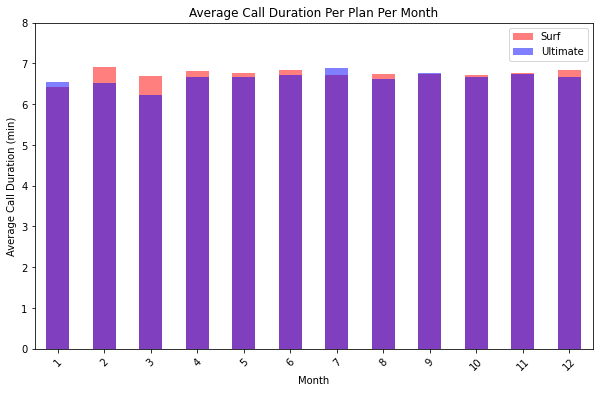

In [209]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

# Surf plan
# Calculate total call time per month
calltime_surf = calls_plan_surf.groupby('month')['min_month'].sum()
# Calculate total number of calls per month
call_total_surf = calls_plan_surf.groupby('month')['calls_month'].sum()

duration_surf = calltime_surf / call_total_surf
print(f'Call duration for the Surf plan: mean: {np.mean(duration_surf)}, stdev: {np.std(duration_surf)}.')

# Ultimate plan
# Calculate total call time per month
calltime_ultimate = calls_plan_ultimate.groupby('month')['min_month'].sum()
# Calculate total number of calls per month
call_total_ultimate = calls_plan_ultimate.groupby('month')['calls_month'].sum()

duration_ultimate = calltime_ultimate / call_total_ultimate
print(f'Call duration for the Ultimate plan: mean: {np.mean(duration_ultimate)}, stdev: {np.std(duration_ultimate)}.')

# Plot as bar
duration_surf.plot(kind='bar', alpha=0.5, color='red', rot=45, ylim=[0, 8], figsize=(10,6))
duration_ultimate.plot(kind='bar', alpha=0.5, color='blue', rot=45)
plt.xlabel('Month')
plt.ylabel('Average Call Duration (min)')
plt.legend(['Surf', 'Ultimate'])
plt.title('Average Call Duration Per Plan Per Month')
plt.show()

What is being shown in the graph above is the average call duration (calculated from the total call minutes divided by the total number of calls) on a per month basis which is separated by the two different plans. Between the two plans, it is almost identical and also because the average call duration is close to one another, there does not appear to be any difference in behavior in terms of call duration between the different plans. This suggest that regardless of the plan that people have, they do not tend to talk longer or shorter depending on what they paid for.

In [210]:
# Calculate the mean and the variance of the monthly call duration
# Surf plan
dur_surf_mean = np.mean(duration_surf)
dur_surf_var = np.var(duration_surf)
print(f'The mean call duration for the Surf plan is {dur_surf_mean} and variance is {dur_surf_var}.')

# Ultimate plan
dur_ult_mean = np.mean(duration_ultimate)
dur_ult_var = np.var(duration_ultimate)
print(f'The mean call duration for the Ultimate plan is {dur_ult_mean} and variance is {dur_ult_var}.')

The mean call duration for the Surf plan is 6.745134009024245 and variance is 0.012751243917720341.
The mean call duration for the Ultimate plan is 6.636680677937407 and variance is 0.02507363103246302.


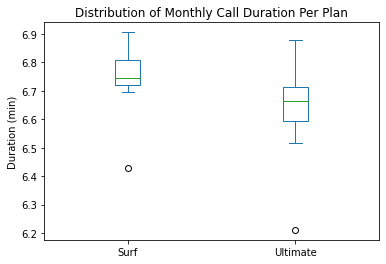

In [211]:
# Plot a boxplot to visualize the distribution of the monthly call duration
merge = duration_surf.reset_index().merge(duration_ultimate.reset_index(), on='month')
merge = merge.set_index('month')

merge = merge.rename(columns = {
    '0_x': 'Surf',
    '0_y': 'Ultimate'
})

merge.plot(kind='box', ylabel='Duration (min)', title='Distribution of Monthly Call Duration Per Plan')
plt.show()

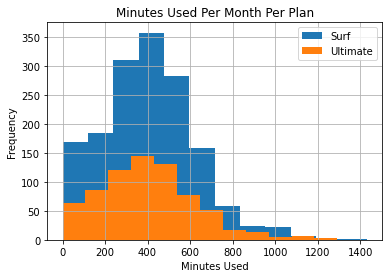

In [212]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
min_required_surf = calls_plan_surf.groupby(['user_id', 'month'])['min_month'].sum()
min_required_ultimate = calls_plan_ultimate.groupby(['user_id', 'month'])['min_month'].sum()

min_required_surf.hist(bins=12)
min_required_ultimate.hist(bins=12)
plt.xlabel('Minutes Used')
plt.ylabel('Frequency')
plt.legend(['Surf', 'Ultimate'])
plt.title('Minutes Used Per Month Per Plan')
plt.show()

Above is a histogram showing the distribution between the two plans on the number of minutes each user is using per month. On a frequency standpoint, we do see that there are more people, at least in this data set, that are signed up for the surf plan. However, when looking at the shape of the curve and distribution of the values, the number of minutes used per month look similar between plans. Most people even in the Surf or Ultimate plans tend to use around 400 minutes per month. 

Overall conclusions on how users behave in terms of calling:

My impressions are that there does not appear to be much or any at all shift in calling behavior in users depending on the plan. This shows in that the average call duration and the minutes used are not drastically different when comparing between the plans. This suggests that the calling behavior stays the same regardless of the plan that they have.

### Messages

In [213]:
# Compare the number of messages users of each plan tend to send each month
msgs_month_surf = calls_plan_surf.groupby('month')['number_of_msgs'].mean()
msgs_month_ult = calls_plan_ultimate.groupby('month')['number_of_msgs'].mean()

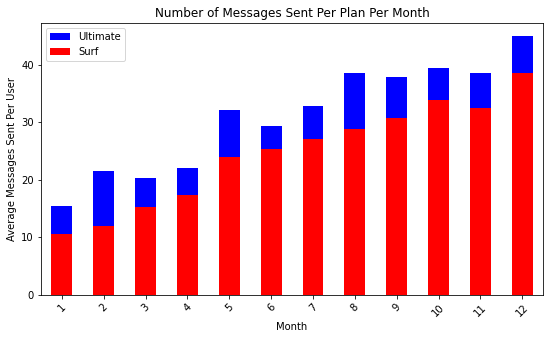

In [214]:
# Plot messages for each plan each month
msgs_month_ult.plot(kind='bar', color='blue', alpha=1, rot=45, figsize=[9, 5])
msgs_month_surf.plot(kind='bar', color='red', alpha=1, rot=45)
plt.xlabel('Month')
plt.ylabel('Average Messages Sent Per User')
plt.title('Number of Messages Sent Per Plan Per Month')
plt.legend(['Ultimate', 'Surf'])
plt.show()

In [215]:
# Calcuating the mean messages sent per user_id per month
msgs_surf = calls_plan_surf.groupby('user_id')['number_of_msgs'].mean()
msgs_ult = calls_plan_ultimate.groupby('user_id')['number_of_msgs'].mean()

print(f'Messages sent/month per user on the Surf plan: mean: {np.mean(msgs_surf)}, variance: {np.var(msgs_surf)}, stdev: {np.std(msgs_surf)}')
print(f'Messages sent/month per user on the Ultimate plan: mean: {np.mean(msgs_ult)}, variance: {np.var(msgs_ult)}, stdev: {np.std(msgs_ult)}')

Messages sent/month per user on the Surf plan: mean: 32.408930792264144, variance: 959.2133180249753, stdev: 30.97116914204201
Messages sent/month per user on the Ultimate plan: mean: 38.4715322009908, variance: 1077.2996431216473, stdev: 32.822243115327254


There is a noticeable difference in the number of messages each user tend to send per month depending on the plan, but possibly not significant given the variance. For each month, it is higher with the Ultimate plan relative to the Surf plan. Since users are spending more on the Ultimate plan which has the higher number of messages allotment, it would make sense that users on this plan tend to send more messages.

### Internet

In [216]:
# Compare the amount of internet traffic consumed by users per plan
data_surf = calls_plan_surf.groupby('month')['gb_month'].mean()
data_ult = calls_plan_ultimate.groupby('month')['gb_month'].mean()

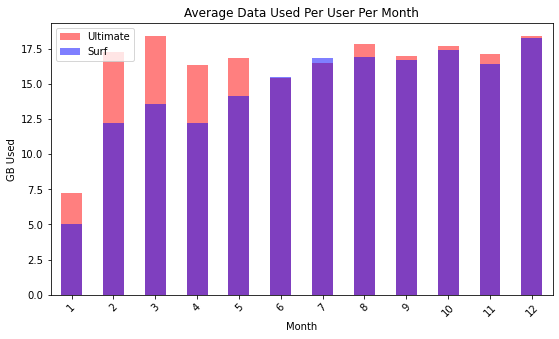

In [217]:
# Plot average data used per user per plan per month
data_ult.plot(kind='bar', color='red', alpha=0.5, rot=45, figsize=[9,5])
data_surf.plot(kind='bar', color='blue', alpha=0.5, rot=45)
plt.xlabel('Month')
plt.ylabel('GB Used')
plt.title('Average Data Used Per User Per Month')
plt.legend(['Ultimate', 'Surf'])
plt.show()

In [218]:
# Calcuating the mean gb_used per user_id per month
gb_surf = calls_plan_surf.groupby('user_id')['gb_month'].mean()
gb_ult = calls_plan_ultimate.groupby('user_id')['gb_month'].mean()

print(f'GB used/month per user on the Surf plan: mean: {np.mean(gb_surf)}, variance: {np.var(gb_surf)}, stdev: {np.std(gb_surf)}')
print(f'GB used/month per user on the Ultimate plan: mean: {np.mean(gb_ult)}, variance: {np.var(gb_ult)}, stdev: {np.std(gb_ult)}')

GB used/month per user on the Surf plan: mean: 15.99696482196484, variance: 37.13372401382804, stdev: 6.093744662670733
GB used/month per user on the Ultimate plan: mean: 16.154847152140135, variance: 33.22285989433508, stdev: 5.763927471293777


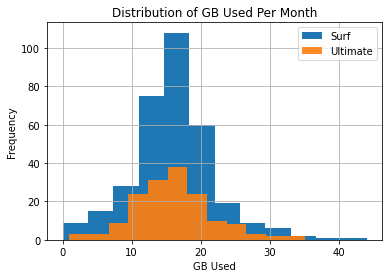

In [219]:
# Histogram of data used per user per month
gb_surf.hist(bins=12)
gb_ult.hist(bins=12, alpha=0.9)
plt.legend(['Surf', 'Ultimate'])
plt.xlabel('GB Used')
plt.ylabel('Frequency')
plt.title('Distribution of GB Used Per Month')
plt.show()

My overall impressions is that there is no apparent differences in the amount of data used per user on the different plans. 

Comparing the averages in GB used/month per user between the Surf and Ultimate plan, the means are 16.0 and 16.15, respectively. Taking into account the variances as well, it suggests that the data usage is very similar. In addition, when looking at the histogram plot showing the data used per user, the distribution is similar, and the most frequent GB used per user is around 20 GB/user/month when looking at both plans.

Looking at the breakdown of data usage per month (shown in the bar plot), data usage is fairly similar when comparing month 6 and onwards. People on the Ultimate plan seem to use more data on months 1 to 5 over the Surf plan.

## Revenue

In [220]:
# Average revenue per user per month - Surf plan
rev_mon_surf = calls_plan_surf.groupby('month')['charge_month'].mean()

# Average revenue per user per month - Ultimate plan
rev_mon_ult = calls_plan_ultimate.groupby('month')['charge_month'].mean()

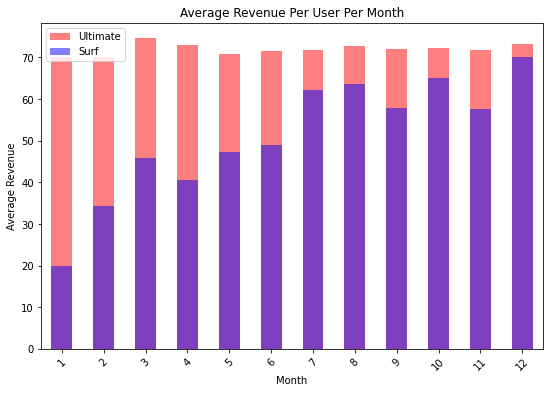

In [221]:
# Plot average revenue per use per month
rev_mon_ult.plot(kind='bar', color='red', alpha=0.5, rot=45, figsize=[9,6])
rev_mon_surf.plot(kind='bar', color='blue', alpha=0.5, rot=45)
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.title('Average Revenue Per User Per Month')
plt.legend(['Ultimate', 'Surf'])
plt.show()

In [222]:
# Calcuating the mean revenue per user_id per month
rev_surf = calls_plan_surf.groupby('user_id')['charge_month'].mean()
rev_ult = calls_plan_ultimate.groupby('user_id')['charge_month'].mean()

print(f'Revenue/month per user on the Surf plan: mean: ${np.mean(rev_surf)}, variance: {np.var(rev_surf)}, stdev: {np.std(rev_surf)}')
print(f'Revenue/month per user on the Ultimate plan: mean: ${np.mean(rev_ult)}, variance: {np.var(rev_ult)}, stdev: {np.std(rev_ult)}')

Revenue/month per user on the Surf plan: mean: $57.837079988744165, variance: 1883.7454443406905, stdev: 43.40213640295476
Revenue/month per user on the Ultimate plan: mean: $71.8232837933475, variance: 54.77601827622787, stdev: 7.401082236823738


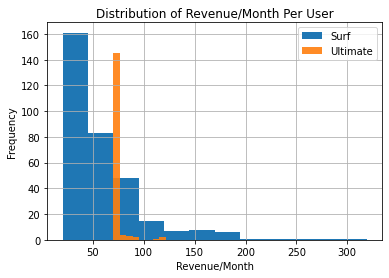

In [223]:
# Histogram of Revenue per user per month
rev_surf.hist(bins=12)
rev_ult.hist(bins=8, alpha=0.9)
plt.legend(['Surf', 'Ultimate'])
plt.xlabel('Revenue/Month')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue/Month Per User')
plt.show()

The average monthly revenue for people in the Surf plan is 57.84 with a high variance, compared to the Ultimate plan of 71.82 with a much lower variance. This is also shown in the histogram plot, where there's more spread in monthly revenue per user in the surf plan compared to the Ultimate plan. 

This indicates that people on the Ultimate plan tend to not overuse the allotted amount in their data plan, while people on the Surf plan tend to use more than the plan allows, leading to paying more over the base charge of the plan. This could mean that the data allowance on the Ultimate plan is too high, and thus less people are able to benefit as much with the increased limits on calling, messages, and data. On the other side, this could also mean that the limits on the Surf plan are low enough that many people tend to use past the limits and end up getting charged more. 

## Test statistical hypotheses

H0 null hypothesis: average user revenue between plans are equal

Alternative hypothesis: average user revenue of surf plan is different than the ultimate plate

In [224]:
# Average user revenue for surf plan
avg_user_rev_surf = calls_plan_surf.groupby('user_id')['charge_month'].mean()

# Average user revenue for ultimate plan
avg_user_rev_ult = calls_plan_ultimate.groupby('user_id')['charge_month'].mean()

In [225]:
# H0 null hypothesis: average user revenue between plans are equal
# Alternative hypothesis: average user revenue of surf plan is different than the ultimate plate

# Test the hypotheses
alpha = 0.01 # significance level

results = st.ttest_ind(avg_user_rev_surf, avg_user_rev_ult)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value: 7.252198062616272e-05
We reject the null hypothesis


We can reject the null hypothesis that the average user revenue between the plans are equal to a significance of less than 0.01. We can say there is a significant difference between the average revenues between people on the Surf plan and the Ultimate plan.

H0 null hypothesis: average user revenue from users in the NY-NJ are the same as users from other regions

Alternative hypothesis: average user revenue are different

In [226]:
# Filter by NY-NJ
merged_nynj = merged_users_plans.query("NYNJ == 1")
merged_not_nynj = merged_users_plans.query("NYNJ == 0")

In [227]:
# Calculate average revenue per user filtered by NYNJ
avg_rev_nynj = merged_nynj.groupby('user_id')['charge_month'].mean()
avg_rev_not_nynj = merged_not_nynj.groupby('user_id')['charge_month'].mean()

In [228]:
#H0 null hypothesis: average user revenue from users in the NY-NJ are the same as users from other regions
#Alternative hypothesis: average user revenue are different

# Test the hypotheses
alpha = 0.05 # significance level

results = st.ttest_ind(avg_rev_nynj, avg_rev_not_nynj)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.4703112160530949
We can't reject the null hypothesis


We cannot reject the null hypothesis, and can say that with statistical significance that the average revenue from users in the NY-NJ area are the same as users from other regions.

## General conclusions

Comparisons between the difference plans month to month by call duration, messages sent, and data used.

<b>Call duration</b>
- Surf plan: average call duration is 6.75, with standard deviation of 0.11.
- Ultimate plan: average call duration is 6.64, with standard deviation of 0.16.

<b>Messages sent</b>
- Surf plan: average messages sent is 32.41, with standard deviation of 30.97.
- Ultimate plan: average messages sent is 38.47, with standard deviation of 32.82

<b>Data usage</b>
- Surf plan: data (GBs) used average is 16.0, with standard deviation of 6.09
- Ultimate plan: data (GBs) used average is 16.15, with standard deviation of 5.76

<b>Revenue</b>
- Surf plan: revenue/month average is 57.84, with standard deviation of 43.4
- Ultimate plan: revenue/month average is 71.82, with standard deviation of 7.4

Overall, general behavior of users in regard to data usage, number of calls and call duration, and messages sent appear to be identical when comparing between the different plans, Surf and Ultimate. Looking at the average values for call duration, messages sent, data used, the average is identical between the plans and within the standard deviation. This indicates that there is no behavioral differences of people's usage on the different plans.

There is more revenue per user with people on the Ultimate plan, despite using similar amounts of data. People in the Surf plan tend to overuse their limits more in the plan, which leads to them paying more over the base compared to people on the Ultimate plan.

Finally, there is no statistical significance that there is more revenue coming in from users in the NY-NJ region compared to the other regions.